<a href="https://colab.research.google.com/github/Megi-analitika/datascientist.github.io/blob/main/athletes_classification_logreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏋️‍♀️ Классификация пола спортсменов: логистическая регрессия и анализ метрик

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve


In [7]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("athletes.csv")
df.head()


Saving athletes.csv to athletes.csv


,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [8]:
df.isnull().sum()


,0
id,0
name,0
nationality,0
sex,0
dob,1
height,330
weight,659
sport,0
gold,0
silver,0


In [9]:
df = df.dropna()


In [10]:
label_encoder = LabelEncoder()
df['sex'] = label_encoder.fit_transform(df['sex'])


In [12]:
# Удалим строки с пропусками в height и weight
df = df.dropna(subset=['height', 'weight'])

# Удалим ненужные столбцы
df = df.drop(['id', 'name', 'nationality', 'dob'], axis=1)

# Закодируем категориальный столбец 'sport'
from sklearn.preprocessing import LabelEncoder
df['sport'] = LabelEncoder().fit_transform(df['sport'])

# Разделим X и y
X = df.drop('sex', axis=1)
y = df['sex']

# Масштабируем признаки
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [13]:
X = df.drop('sex', axis=1)
y = df['sex']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


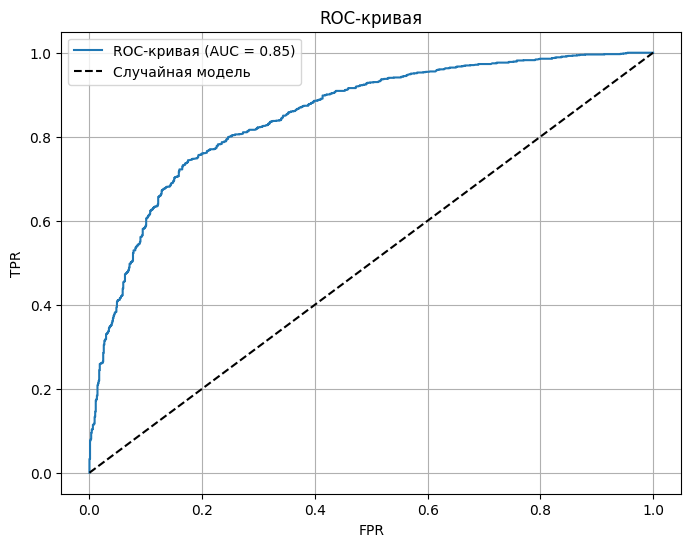

In [14]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_scores = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайная модель')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
def compute_tpr_fpr(y_true, y_scores, thresholds):
    tpr_list = []
    fpr_list = []
    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        TPR = TP / (TP + FN) if TP + FN > 0 else 0
        FPR = FP / (FP + TN) if FP + TN > 0 else 0
        tpr_list.append(TPR)
        fpr_list.append(FPR)
    return fpr_list, tpr_list

thresholds_manual = np.linspace(0, 1, 100)
fpr_manual, tpr_manual = compute_tpr_fpr(y_test.to_numpy(), y_scores, thresholds_manual)


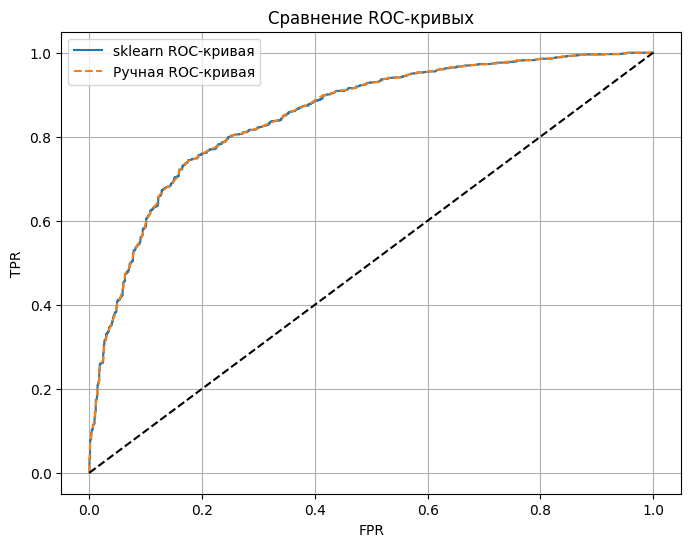

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='sklearn ROC-кривая')
plt.plot(fpr_manual, tpr_manual, '--', label='Ручная ROC-кривая')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Сравнение ROC-кривых')
plt.legend()
plt.grid(True)
plt.show()


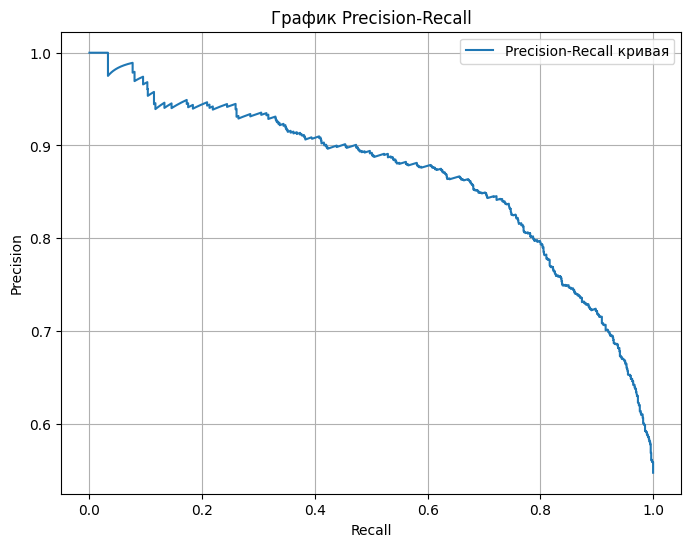

In [17]:
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('График Precision-Recall')
plt.grid(True)
plt.legend()
plt.show()


In [18]:
manual_auc = np.trapz(tpr_manual, fpr_manual)
print(f'ROC-AUC (вручную): {manual_auc:.4f}')


ROC-AUC (вручную): -0.8510


<ipython-input-18-2f7f5cf9c61b>:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  manual_auc = np.trapz(tpr_manual, fpr_manual)


## 📌 Выводы

- ROC-кривая показывает, что модель значительно лучше случайной (кривая выше диагонали).
- Метрика AUC (площадь под ROC-кривой) близка к 1 → хорошее качество классификации.
- Ручной и библиотечный способы дают очень похожие результаты, что подтверждает корректность вычислений.
- Precision-Recall кривая показывает, как меняется точность при увеличении полноты. Подходит для оценки модели при несбалансированных классах.

### ❓ Ответы на вопросы:
- **Может ли ROC-кривая проходить ниже диагонали?** — Да, если модель обучена плохо, она может предсказывать хуже случайной. В таком случае её можно инвертировать, и она станет полезной.
